# Линейная классификация

Задачей линейной классификации является построение линейной поверхности, которая разделяет пространство признаков на два класса. Если речь идет о бинарной классификации (т.е. целевых классов всего два), то такой поверхностью является гиперплоскость (прямая в двухмерном пространстве, плоскость в трехмерном и т.д.). В общем случае при разделении на многие классы, поверхность является кусочно-линейной.

## Теория

Очевидно, что если у нас введена линейная поверхность, то знак скалярного произведения нормали этой верхности и произвольного вектора указывает, с какой стороны поверхности стоит та или иная точка. Таким образом, задача сводится к нахождению вектора нормали линейной поверхности, которая наилучшим образом делит пространство. Дополнительно вводится порог принятия решения, который позволяет не классифицировать точки, которые стоят слишком близко к разделяющей поверхности.

Мы рассмотрим метод классификации с учителем, который основан на логистической регрессии. В ней используется [логистическая сигмоида](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0), которая на практике указывает, с какой вероятностью точка принадлежит к целевому классу.
 
При решении задачи с несколькими классами (>2) используется либо подход multinomial, либо one-versus-rest. В первом случае строится набор поверхностей, которые разделяют все классы между собой, а во втором - для каждого класса строится поверхность, которая отделяет его от остальных. Первый подход требует большего числа вычислений, но, как правило, дает лучший результат.

Очевидно, что комбинация нелинейного преобразования пространства признаков и линейного классификатора, определенного в преобразованном пространстве, дает нелинейный классификатор.

Сама задача поиска оптимальной поверхности для разделения пространства может решаться как поиск экстремума функции потерь.

Также ясно, что метод "k ближайших соседей" в пространстве с эвклидовой метрикой дает кусочно линейное разбиение пространства. В частном случае, если заданы всего две точки, то разбиение будет осуществляться по гиперплоскости.

## Практика

Давайте попробуем метод линейной классификации на датасете wine пакета scikit_learn:

In [1]:
from sklearn.datasets import load_wine

wine_dataset = load_wine()

Посмотрим, какие признаки содержатся в датасете:

In [2]:
print("Признаки:\n{}".format(wine_dataset['feature_names']))

Признаки:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Согласно [описанию](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine), датасет содержит вина трех классов:

In [3]:
print("Классы: {}".format(wine_dataset['target_names']))

Классы: ['class_0' 'class_1' 'class_2']


К сожалению, датасет не содержит описания самих классов, поэтому будем решать generic задачу классификации, не вдаваясь в значение самих классов.

Как мы помним из предыдущей лекции, sklearn позволяет нам разбить датасет на обучающую и тестовую выборку в соотношении 75/25:

In [4]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(wine_dataset['data'], wine_dataset['target'], random_state=15)

Посмотрим, насколько хорошо или плохо разделяются наши классы в исходных данных:

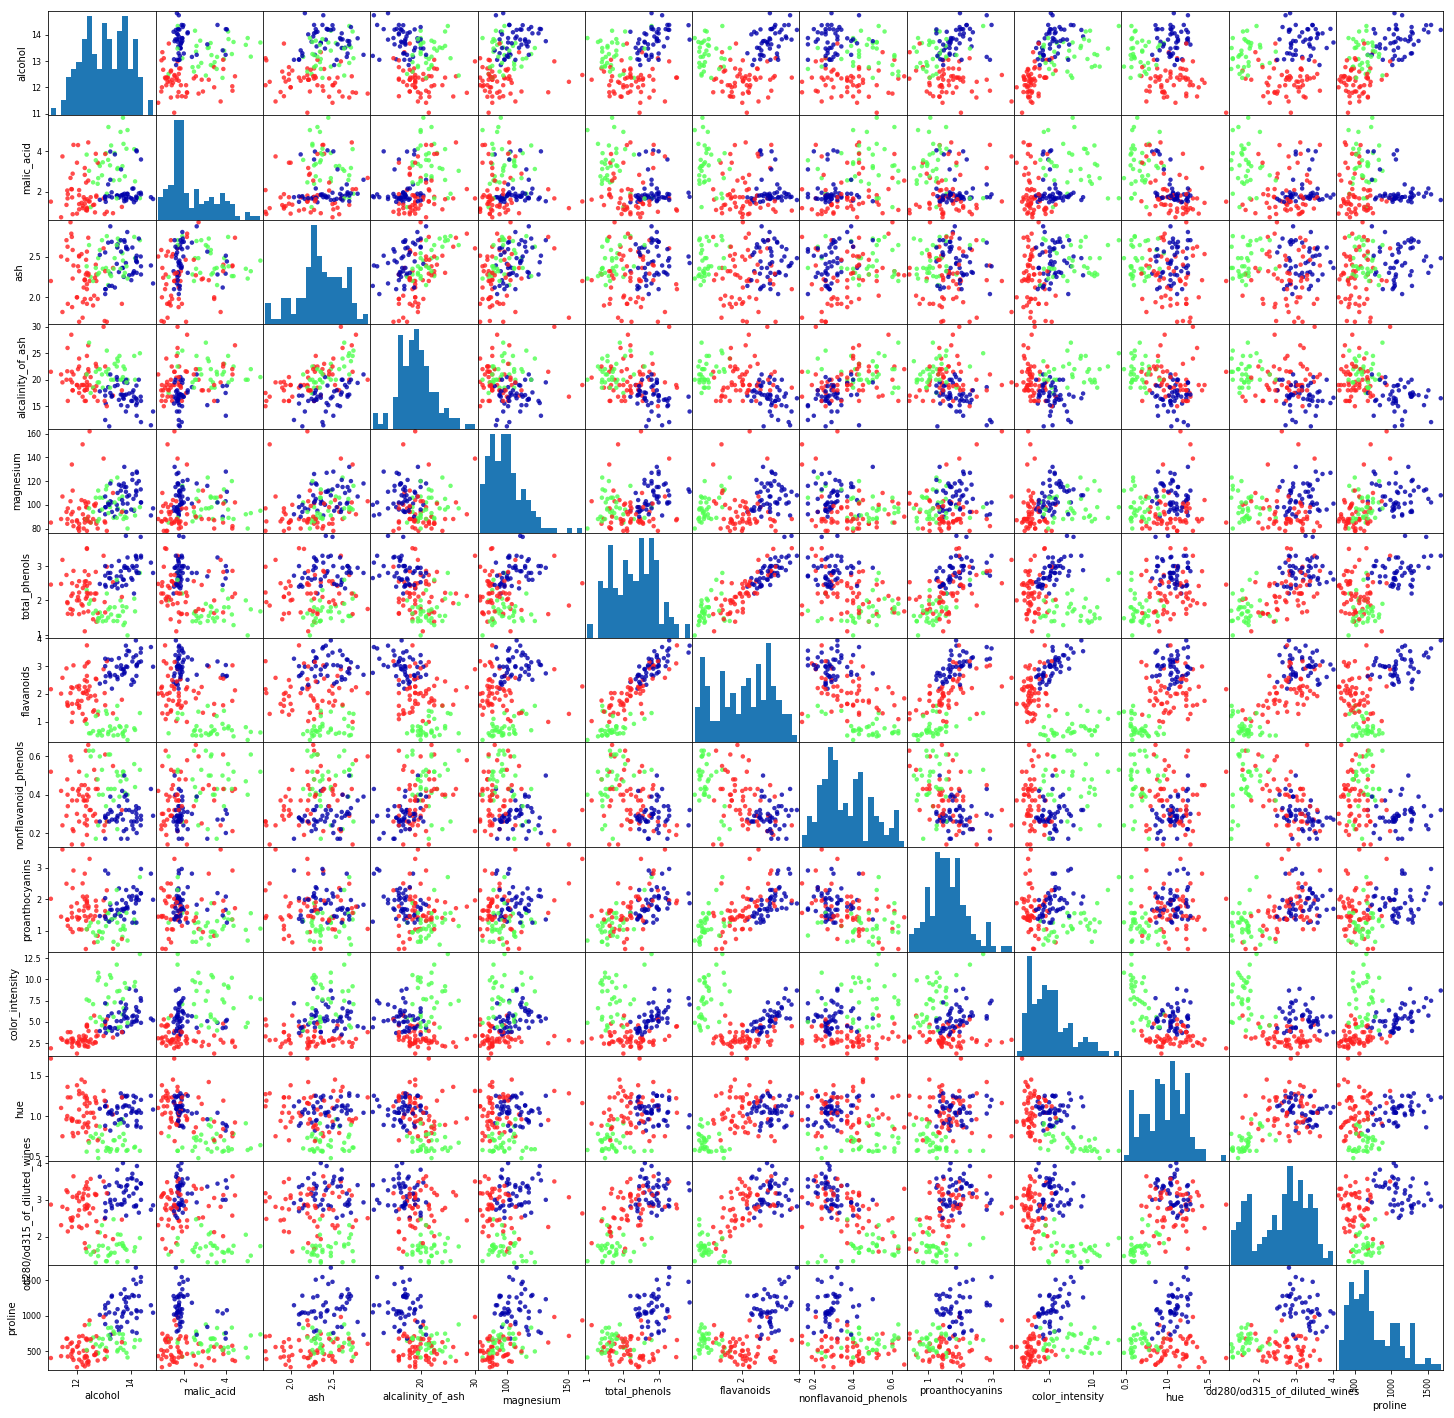

In [21]:
import pandas as pd
import mglearn

df = pd.DataFrame(X_train, columns=wine_dataset.feature_names)

grr = pd.plotting.scatter_matrix(df, c=y_train, figsize=(25, 25), marker='o', hist_kwds={'bins': 20}, s=20, alpha=.8, cmap=mglearn.cm3)

Признаков очень много, поэтому визуализация получается достаточно перегруженной, но можно заметить, что в классы четко разделяются в строках alcohol и proline. Например, четко выделяются классы в плоскостях alcohol / od280/od315_of_diluted_wines и proline / od280/od315_of_diluted_wines, двайте взглянем на них:

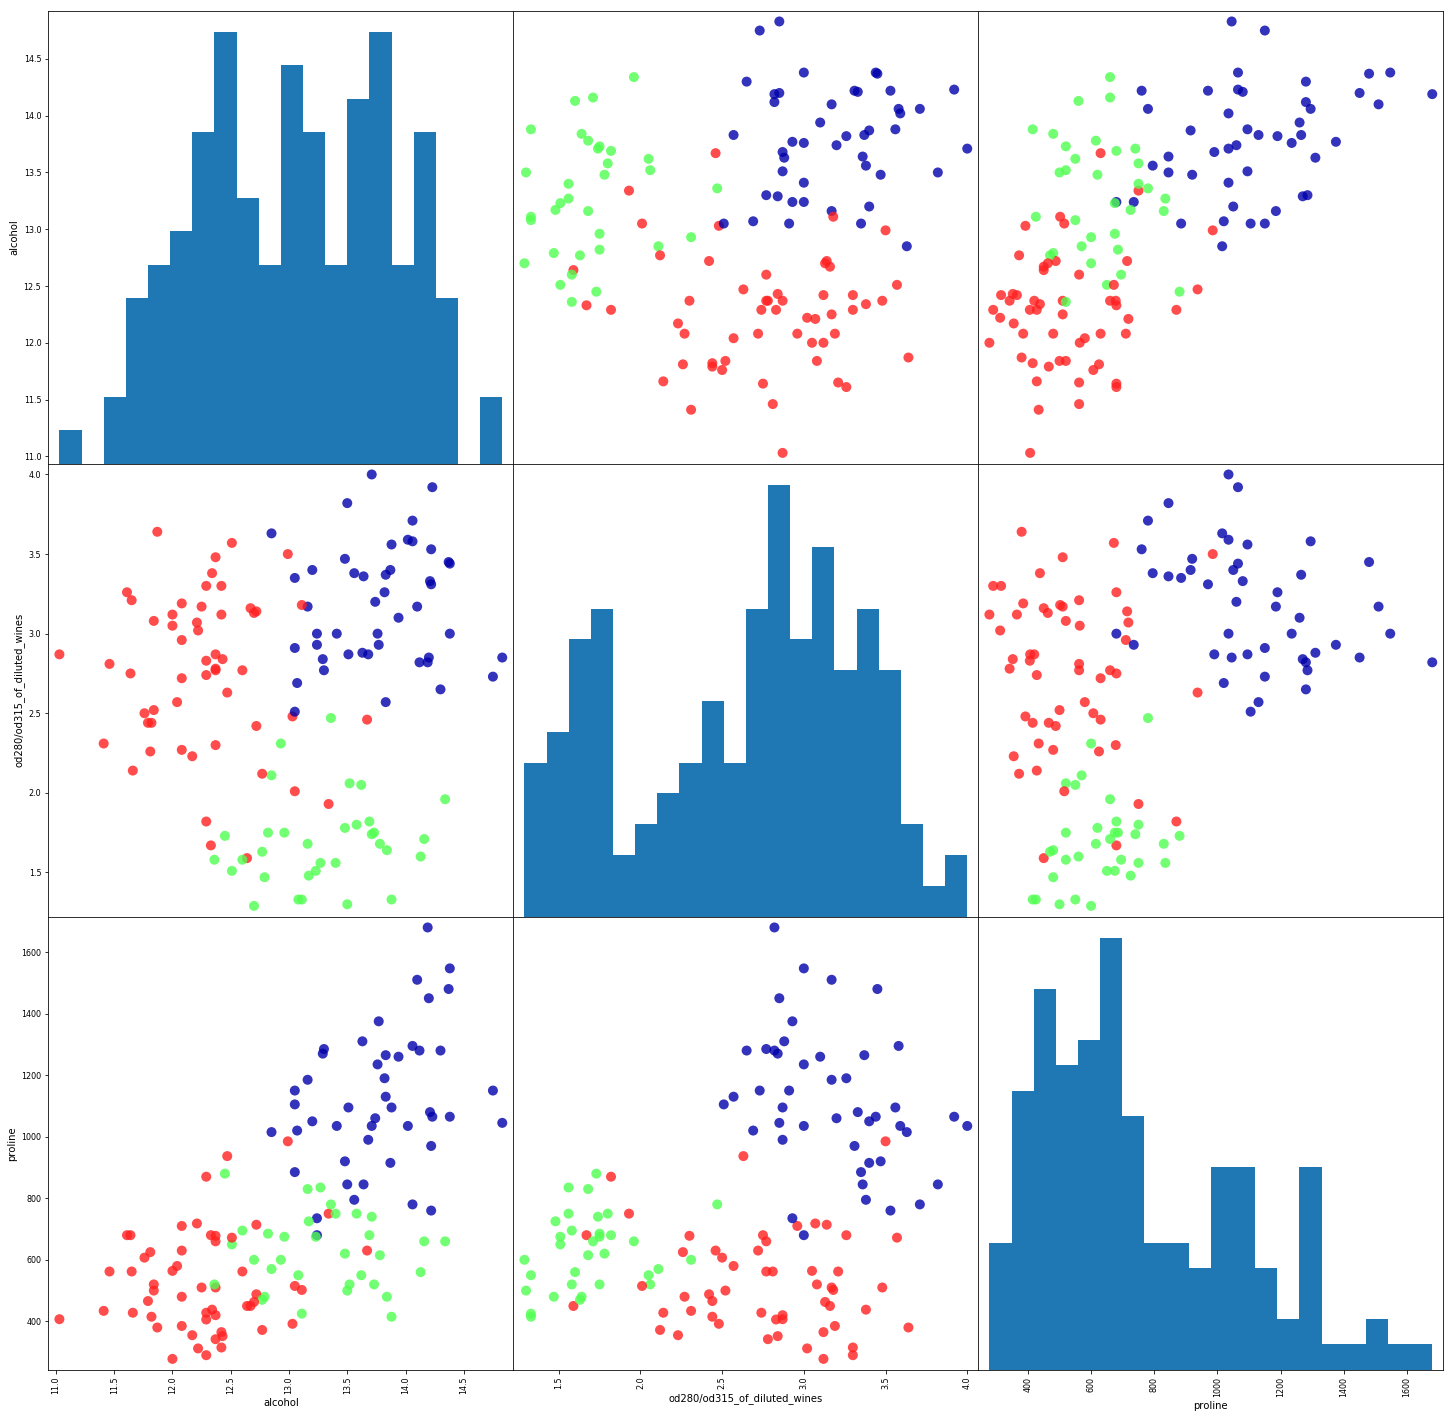

In [6]:
selection = df[['alcohol', 'od280/od315_of_diluted_wines', 'proline']]

grr = pd.plotting.scatter_matrix(selection, c=y_train, figsize=(25, 25), marker='o', hist_kwds={'bins': 20}, s=100, alpha=.8, cmap=mglearn.cm3)

В будущем мы рассмотрим метод анализа принципиальных компонент (PCA), который позволит переходить к проекциям на подпространства заданной размерности с минимальной потерей вариативности в данных, но пока нам достаточно, что в исходных данных есть подпространства, проекции в которые могут дать удовлетворительный результат, чтобы сделать вывод о том, что классификация может быть проведена успешно.

Задачу будем решать при помощи логистической регрессии. Сначала попробуем решить на плоскости alcohol / od280/od315_of_diluted_wines:

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e4, solver='lbfgs', multi_class='multinomial', max_iter=10000)

selection = pd.DataFrame(X_train, columns=wine_dataset.feature_names)[['alcohol', 'od280/od315_of_diluted_wines']]

result = logreg.fit(selection, y_train)

In [8]:
test_selection = pd.DataFrame(X_test, columns=wine_dataset.feature_names)[['alcohol', 'od280/od315_of_diluted_wines']]

print("Точность на тестовом наборе: {:.2f}".format(logreg.score(test_selection, y_test)))

Точность на тестовом наборе: 0.87


Как видно, мы добились точности в 0.87 на тестовой выборке. Изобразим наши классы на графике (для этого обратимся к [примеру](http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py)):

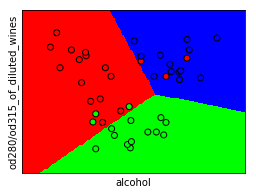

In [31]:
import numpy as np
import matplotlib.pyplot as plt

X = test_selection.values
Y = y_test

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.brg)

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.brg)
plt.xlabel('alcohol')
plt.ylabel('od280/od315_of_diluted_wines')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

Ну и теперь попробуем не ограничиваться данными только из двух размерностей и построим классификатор на основе всех тех данных, что у нас есть:

In [58]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e4, solver='lbfgs', multi_class='multinomial', max_iter=10000)

selection = pd.DataFrame(X_train, columns=wine_dataset.feature_names)[['alcohol', 'od280/od315_of_diluted_wines']]

logreg.fit(X_train, y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [59]:
print("Точность на тестовом наборе: {:.2f}".format(logreg.score(X_test, y_test)))

Точность на тестовом наборе: 0.96


Как видно, при увеличении размерности исходных данных с 2 до 13, точность возрасла с 0.87 до 0.96. Очевидно, что не все признаки позволяют нам эффективно строить классификатор. Чтобы уменьшить количество данных, которое мы используем при классификации как раз и применяется подход PCA.